## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#%config InlineBackend.figure_format='retina'

from moviepy.editor import VideoFileClip
from IPython.display import HTML


## Create global variables

In [2]:
cameraMatrix = None
distortionCoeffs = None

# Camera calibration

In [109]:

def calibration(path_to_images):
    """
    Given a set of images (checerboards with 9x6 internal points), this
    will create the cameraMatrix and distoritionCoefficients that will
    be used to undistort the image.
    """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(path_to_images)

    # Step through the list and search for chessboard corners
    gray_shape = None
    for fname in images:
        # open and convert to grayscale
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        gray_shape = gray.shape

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    # calibrate the camera and return the cameraMatrix and distortionCoefficients
    ret, mtx, distortion, _, _ =  cv2.calibrateCamera(objpoints,
                                                      imgpoints,
                                                      gray_shape[::-1],
                                                      None, None)
    return mtx, distortion

#
# The cameraMatrix and distortionCoeffs are used when undistorting images
#
cameraMatrix, distortionCoeffs = calibration('./camera_cal/calibration*.jpg')

# Undistort  images


In [110]:
def undistortImage(image):
    """
    Given the cameraMatrix and the distortionCoefficients generated by the
    calibration() function, this will undistort the image.
    """
    assert cameraMatrix is not None, "calibration() not run"
    assert distortionCoeffs is not None, "calibration() not run"

    return cv2.undistort(image, cameraMatrix, distortionCoeffs, None, cameraMatrix)

# Basic Thresholding Algorithms

In [111]:
def abs_sobel_thresh(gray, orient='x', sobel_kernel=(3,3), thresh=(0,255)):
    """
    Creates a filter, based on the Sobel operator, in either the x or y axis,
    depending on the orient parameter.    
    """
    # Apply the following steps to img
    # 1) Convert to grayscale (input is already grayscale)
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    # 3) Take the absolute value of the derivative or gradient
    sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * sobel / np.max(sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    binary_mask = np.zeros_like(scaled_sobel)
    binary_mask[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_mask
    
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    """
    Creates a binary mask of an image based on the direction of the gradient.
    The size of the kernel is controlled by the sobel_kernel parameter.
    The lower and upper bounds for the thresholding is set by the thresh parameter.
    """
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir = np.arctan2(abs_sobely, abs_sobelx)
    binary_mask = np.zeros_like(abs_sobelx)
    binary_mask[(dir >= thresh[0]) & (dir <= thresh[1])] = 1
    return binary_mask

def mag_thresh(gray, sobel_kernel=3, thresh=(0, 255)):
    """
    Creates a binary mask of the image based on the magnitude of the gradient,
    in both the x and y directions.
    """
    # Apply the following steps to img
    # 1) Convert to grayscale (input is already grayscale)
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude
    dist = np.sqrt(sobelx*sobelx + sobely*sobely)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255 * dist / np.max(dist))

    # 5) Create a binary mask where mag thresholds are met
    binary_mask = np.zeros_like(scaled_sobel)
    binary_mask[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_mask



# Final thresholding transform

In [112]:
class ThresholdTransform(object):
    def create_thresholded_image(self, image):
        img = np.copy(image)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        s_channel = hls[:, :, 2]

        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
        s2_channel = hsv[:, :, 1]

        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= 150) & (s_channel <= 255)] = 1

        gradx = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=5, thresh=(10,250))

        s2_binary = np.zeros_like(s2_channel)
        s2_binary[(s2_channel >= 200) & (s2_channel <= 255)] = 1


        combined = np.zeros_like(s_binary)
        combined[((s_binary == 1) | (gradx == 1)) | (s2_binary == 1)] = 1

        return combined
    
threshold = ThresholdTransform()

# Perspective transform

In [113]:
class PerspectiveTransform(object):
    def __init__(self, src_points, dest_points):
        self.M = cv2.getPerspectiveTransform(src_points, dest_points)
        self.Minv = cv2.getPerspectiveTransform(dest_points, src_points)
        
    def warp(self, image):
        return cv2.warpPerspective(image, self.M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    
    def unwarp(self, image):
        return cv2.warpPerspective(image, self.Minv, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)


# Fitting a polynomial

In [220]:

def evaluate_poly(coeffs, pts):
    return coeffs[0]*(pts**2) + coeffs[1]*pts + coeffs[2]


class PolynomialFitting(object):
    """
    Fit the lane lines in an image to a polynomial
    with sliding windows.
    """

    def __init__(self, num_windows=9, margin=100, minpix=50):
        self.num_windows = num_windows
        self.margin = margin
        self.minpix = minpix
        self.lane_center = None

    def fit_to_image(self, image):
        image = np.copy(image)
        # take histogram of bottom half of image
        histogram = np.sum(image[image.shape[0]//2:, :], axis=0)

        # Find the peak of left/right halves of image
        midpoint = np.int(histogram.shape[0]/2)
        base = (np.argmax(histogram[:midpoint]),
                np.argmax(histogram[midpoint:]) + midpoint)
        self.lane_center = (base[0], base[1])

        window_height = np.int(image.shape[0]/self.num_windows)

        # identify x,y positions of all nonzero pixels
        nonzero = image.nonzero()
        nonzerox = np.array(nonzero[1])
        nonzeroy = np.array(nonzero[0])
        
        # current position
        current = list(base)

        left_lane_indices = []
        right_lane_indices= []
        
        left_windows = list()
        right_windows = list()

        for window in range(self.num_windows):
            # identify window boundaries (low, high)
            win_y = (image.shape[0] - (window+1)*window_height,
                     image.shape[0] - window*window_height)
            win_xleft = (current[0] - self.margin,
                         current[0] + self.margin)
            win_xright = (current[1] - self.margin,
                          current[1] + self.margin)

            # draw the windows on the output_image
            left_windows.append( [ (win_xleft[0], win_y[0]), (win_xleft[1], win_y[1]) ])
            right_windows.append( [ (win_xright[0], win_y[0]), (win_xright[1], win_y[1]) ] )

            # identify the nonzero pixels within the window
            good_left_indices = ((nonzeroy >= win_y[0]) &
                                 (nonzeroy <  win_y[1]) &
                                 (nonzerox >= win_xleft[0]) &
                                 (nonzerox <  win_xleft[1])).nonzero()[0]
            good_right_indices = ((nonzeroy >= win_y[0]) &
                                  (nonzeroy <  win_y[1]) &
                                  (nonzerox >= win_xright[0]) &
                                  (nonzerox <  win_xright[1])).nonzero()[0]

            # append indices to the lists
            left_lane_indices.append(good_left_indices)
            right_lane_indices.append(good_right_indices)
    
            # recenter if needed (if > minpix)
            if len(good_left_indices) > self.minpix:
                current[0] = np.int(np.mean(nonzerox[good_left_indices]))
            if len(good_right_indices) > self.minpix:
                current[1] = np.int(np.mean(nonzerox[good_right_indices]))

            # save off the center
            self.lane_center = (current[0], current[1])

        # save windows
        self.left_windows = left_windows
        self.right_windows = right_windows
        
        # concatenate the arrays
        left_lane_indices = np.concatenate(left_lane_indices)
        right_lane_indices = np.concatenate(right_lane_indices)

        # extract left and right lane pixel positions
        self.leftx = nonzerox[left_lane_indices]
        self.lefty = nonzeroy[left_lane_indices]
        self.rightx = nonzerox[right_lane_indices]
        self.righty = nonzeroy[right_lane_indices]

        # fit a second-order polynomial
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)

    def left_poly(self, y):
        return evaluate_poly(self.left_fit, y)

    def right_poly(self, y):
        return evaluate_poly(self.right_fit, y)
    
    def next_image_fit(self, image):
        """
        Tries to fit the current fit to the new image.
        This does not actually update the current values in this object,
        but returns an object that can be used to update this object.
        """
        nonzero = image.nonzero()    
        nonzerox = np.array(nonzero[1])
        nonzeroy = np.array(nonzero[0])
        
        left_eval = self.left_poly(nonzeroy)
        right_eval = self.right_poly(nonzeroy)

        left_lane_indices = ((nonzerox > (left_eval - self.margin)) & (nonzerox < (left_eval + self.margin)))
        right_lane_indices = ((nonzerox > (right_eval - self.margin)) & (nonzerox < (right_eval + self.margin)))

        # Extract left and right pixel positions
        leftx = nonzerox[left_lane_indices]
        lefty = nonzeroy[left_lane_indices]
        rightx = nonzerox[right_lane_indices]
        righty = nonzeroy[right_lane_indices]

        if len(lefty) == 0 or len(righty) == 0:
            return { "error" : "could not find any points"}

        # Fit to a 2nd order polynomial
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Find the lane center from the image
        left_center = np.sum(leftx) / len(leftx)
        right_center = np.sum(rightx) / len(rightx)

        # Find the peak of left/right halves of image
        # Calculate the center of the two peaks
        center = (left_center, right_center)

        return {
            "leftx" : leftx,
            "lefty" : lefty,
            "rightx" : rightx,
            "righty" : righty,
            "left_fit" : left_fit,
            "right_fit" : right_fit,
            "center" : (left_center, right_center)
        }

    def update(self, data):
        self.left_windows = []
        self.right_windows = []

        self.leftx = data['leftx']
        self.lefty = data['lefty']
        self.rightx = data['rightx']
        self.righty = data['righty']
        self.left_fit = data['left_fit']
        self.right_fit = data['right_fit']
        
        self.lane_center = data['center']
        
    def as_data(self):
        return {
            "leftx": self.leftx,
            "lefty" : self.lefty,
            "rightx" : self.rightx,
            "righty" : self.righty,
            "left_fit" : self.left_fit,
            "right_fit" : self.right_fit,
            "center" : self.lane_center,
        }


# Utility code to draw a rectangle

In [198]:
def plot_rectangle(plt, coords, color, width=2):
    """
    This code will plot a rectangle given the top left and bottom right corners.
    """
    pt1, pt2 = coords[0], coords[1]
    plt.vlines(pt1[0], pt1[1], pt2[1], colors=color)
    plt.vlines(pt2[0], pt1[1], pt2[1], colors=color)
    plt.hlines(pt1[1], pt1[0], pt2[0], colors=color)
    plt.hlines(pt2[1], pt1[0], pt2[0], colors=color)

# Utility class to contain per-Lane information

In [221]:
# Create the Line class to hold the information for each line
# To reuse the classes, will also keep the PolynomialFitting class that fits
# both sides

class Line():
    """
    Maintains the information about a line in the lane finding code.
    There should be two instances of this class, one for the left
    side and one for the right side.
    """
    
    def __init__(self, window_size=3):
        # the window size used to calculate the moving average
        self.window_size = window_size
        
        # polynomial coefficients averaged over the last n iterations
        self.current_fit = None
        
        # polynomial coefficients for the last n iterations
        self.recent_fits = []
        
        # last lane center averaged over n iterations
        self.current_center = None
        
        # lane centers for the last n iterations
        self.recent_centers = []

    def clear(self):
        self.current_fit = None
        self.recent_fits = []
        
        self.current_center = None
        self.recent_centers = []
        
    def update(self, coeffs, center):
        if len(self.recent_fits) >= self.window_size:
            self.recent_fits = self.recent_fits[1:]
        self.recent_fits.append(coeffs)
        
        if len(self.recent_centers) >= self.window_size:
            self.recent_centers = self.recent_centers[1:]
        self.recent_centers.append(center)
        
        # calculate the average of the set of coefficients
        self.current_fit = np.mean(self.recent_fits, axis=0)
        self.current_center = np.mean(self.recent_centers)


# The LaneFinder object

In [230]:
import collections

class LaneFinder():
    def __init__(self, src_points, dest_points, sliding_window_depth=3, curvature_calculator=None):
        """
        Performs the processing to determine the two lines (left and right) for the
        traffic lane.
        
        Also maintains the history of the line (for a single lane)
        We do this by keeping the average for the past few windows (determined by
        the sliding_window_depth parameter).
        
        """
        self.curvature_calculator = curvature_calculator
        self.perspective = PerspectiveTransform(src_points, dest_points)
        self.threshold = ThresholdTransform()

        # define conversion from pixel space to meters
        #
        # values for the curvature taken from looking at the warped images
        # and trying to estimate the dimensions of the image (in meters)
        self.xm_per_pix = 3.7/650 # meters per pixel in the x dimension
        self.ym_per_pix = 3.6/80  # meters per pixel in the y dimension
      

        self.sliding_window_depth = sliding_window_depth
        self.left_lane = Line(self.sliding_window_depth)
        self.right_lane = Line(self.sliding_window_depth)
        
        # Reset the line fitting after 3 consecutive bad images
        self.bad_images_reset = 5
        
        # Number of times since the last good line (i.e. bad image count)
        # This is compared to some threshold value
        #   below the threshold -> reuse current line
        #   over the threshold -> search the image from scratch
        # If this is 0, then the last line was good
        # If this is -1, then the full image will be refreshed
        self.bad_image_count = -1

        self.pfit = PolynomialFitting(num_windows=9, margin=100, minpix=50)
        
        self.stats = collections.Counter()
        
        # TODO: adjust the image size, for now assume a fixed-size height
        # that is determined by the first time the image is fit
        # This is the maximum y-value for the image, that is the bottom of the image
        self.image_height = None
        self.image_width = None

    def clear_lane_info(self):
        """
        Removes any data set for the right/left lane.
        """
        self.left_lane.clear()
        self.right_lane.clear()

    def update_lane_info(self):
        """
        Updates the line (left and right) information
        """
        self.left_lane.update(self.pfit.left_fit, self.pfit.lane_center[0])
        self.right_lane.update(self.pfit.right_fit, self.pfit.lane_center[1])
        
    def calculate_curvature(self, data=None):
        """
        Calculate the curvature of the left and right lanes.
        """
        if data is None:
            data = self.pfit.as_data()
        left_fit_cr = np.polyfit(data['lefty']*self.ym_per_pix, data['leftx']*self.xm_per_pix, 2)
        right_fit_cr = np.polyfit(data['righty']*self.ym_per_pix, data['rightx']*self.xm_per_pix, 2)

        # calculate new radii of curvature
        y_eval = (self.image_height-1)*self.ym_per_pix / 2
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        return (min(8000, left_curverad), min(8000, right_curverad))
    
    def sanity_check(self, data):
        """
        Performs a sanity check on the fitted lines.
        Returns true if the lines are ok.
        Returns false if the lines do not pass the tests and should be rejected.
        """

        # Was there an error with the algorithm?
        if 'error' in data:
            #print("sanity check: error: {0}".format(data['error']))
            self.stats['sanity_check::data_error'] += 1
            return False

        centers = data['center']
        
        center = (centers[0] + centers[1]) / 2.0
        off_center = (center - (self.image_width/2)) * self.xm_per_pix
        if abs(off_center) > 0.9:
            #print("sanity_check failed: image too off center : {0}".format(off_center))
            self.stats['sanity_check::off_center'] += 1
            return False
        
        if abs(centers[0] - self.left_lane.current_center)*self.xm_per_pix > 0.5:
            #print("sanity_check failed: left lane too off center : {0}".format(abs(centers[0] - self.left_lane.current_center)*self.xm_per_pix))
            self.stats['sanity_check::left_off_center'] += 1
            return False
        if abs(centers[1] - self.right_lane.current_center)*self.xm_per_pix > 0.5:
            #print("sanity_check failed: right lane too off center : {0}".format(abs(centers[1] - self.right_lane.current_center)*self.xm_per_pix))
            self.stats['sanity_check::right_off_center'] += 1
            return False
        
        # Maintain running average of centers
        # Reject if center is too far off from previous centers

        # Check that the two lines are roughly parallel
        # Get the curve at 10 different points, they should all be (roughly) the
        # same distance apart
        # Generate the curves, assume that they are most likely to be correct
        # near the bottom, so take that value as a baseline. If the curves
        # at the top are off by more than 2x the bottom distance, then they
        # are too far aprt.
        y = np.linspace(0, self.image_height-1, 10)
        
        # Check to see that the bottom of the curve is within the frame
        if evaluate_poly(data['right_fit'], self.image_height-1) > self.image_width:
            #print('sanity check failed: curve off the right end of the image')
            self.stats['sanity_check::curve off right edge of frame'] += 1
            return False

        if evaluate_poly(data['left_fit'], self.image_height-1) < 0:
            #print('sanity check failed: curve off the left end of the image')
            self.stats['sanity_check::curve off left edge of frame'] += 1
            return False


        leftx = evaluate_poly(data['left_fit'], y)
        rightx = evaluate_poly(data['right_fit'], y)
        
        bottom_distance = rightx[-1] - leftx[-1]
        
        # check that all distances are < 2*bottom_distance
        is_bottom = (rightx - leftx) > 2*bottom_distance
        if sum(is_bottom) > 1:
            #print("sanity check failed: curves are not parallel")
            self.stats['sanity_check::not_parallel'] += 1
            return False
        
        
        # Check that the left/right curvatures are roughly equal (if below a threshold)
        left_curve, right_curve = self.calculate_curvature(data)
        
        # Let's just say that the curvature must be within 5 x min
        left_curve = min(10000, left_curve)
        right_curve = min(10000, right_curve)
        min_curve = min(left_curve, right_curve)
        if left_curve > 5*min_curve or right_curve > 5*min_curve:
            #print("sanity check failed: curvatures are too different: {0}".format((left_curve, right_curve)))
            self.stats['sanity_check::curvature_failure'] += 1
            return False
        
        #if left_curve < 100 or right_curve < 100:
        #    print("sanity check failed: curvature too small : {0}".format((left_curve, right_curve)))
        #    self.stats["sanity_check::curvature_too_small"] += 1
        #    return False
        return True
    
    def determine_fit(self, binary_warped):
        """
        Perform the checks and determine how to use the image (it will
        have been transformed and thresholded).
        
        This implementes the control logic.
        """
        # special case for the very first run through the images
        if self.bad_image_count == -1:
            self.bad_image_count = 0
            self.pfit.fit_to_image(binary_warped)
            
            # This is the maximum y-value of the image (the bottom of the image)
            self.image_height = binary_warped.shape[0]
            self.image_width = binary_warped.shape[1]
            self.ploty = np.linspace(0, self.image_height-1, self.image_height)
            
            self.clear_lane_info()
            self.update_lane_info()
            return

        #
        # Treat this as if data has already been run through the image
        #
        data = self.pfit.next_image_fit(binary_warped)

        #
        # Control logic: what do we do with the results for this image
        #
        if self.sanity_check(data) == False:
            #
            # The sanity check failed, reject this image
            # Keep the current fit (to use to determine the lane)
            #
            self.bad_image_count += 1
            self.stats['sanity_check_failed'] += 1
        else:
            #
            # The sanity check succeeded, so reset the bad_image_count to 0
            #
            self.bad_image_count = 0
            self.stats['sanity_check_passed'] += 1
        
        #
        # Now determine what to do based on the number of
        # consecutive bad images seen
        #
        if self.bad_image_count >= self.bad_images_reset:
            #
            # We've hit the threshold for the number of consecutive
            # bad images in a row.  Do a full reset using the current frame.
            #
            self.bad_image_count = 0
            self.pfit.fit_to_image(binary_warped)

            # Clear the lane info
            self.clear_lane_info()
            self.update_lane_info()

            self.stats['image_full_reset'] += 1
            
        elif self.bad_image_count > 0:
            #
            # We've found a bad image, but it's under the threshold
            # Continue using the previous information
            # Nothing to do, do not update the fit object or lane info
            self.stats['image_skipped'] += 1
            pass

        elif self.bad_image_count == 0:
            #
            # This image is good, update the information
            #
            self.pfit.update(data)            
            self.update_lane_info()
            self.stats['image_ok'] += 1

    def process_image(self, image):
        """
        Process a single video frame
        Returns the final output (image which we draw on)
        """
        if self.curvature_calculator is not None:
            self.curvature_calculator.process_image(image)

        undistorted_image = undistortImage(image)
        warped = self.perspective.warp(undistorted_image)
        binary_warped = self.threshold.create_thresholded_image(warped)
        
        # Now that the image is ready to be used, run it through
        # the proper logic (sanity checks etc...)
        self.determine_fit(binary_warped)
                
        # ok, at this point the lines should have the proper coefficients
        # so use those to draw the lines on the image
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
        # recast x, y points into usuable format for cv2.fillPoly()
        # Get the average coefficients
        left_coeff, right_coeff = self.left_lane.current_fit, self.right_lane.current_fit
        left_fitx = evaluate_poly(left_coeff, self.ploty)
        right_fitx = evaluate_poly(right_coeff, self.ploty)
    
        pts_left = np.array([np.transpose(np.vstack([left_fitx, self.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, self.ploty])))])
        pts = np.hstack((pts_left, pts_right))
    
        # draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
        # warp the blank back to original image space
        newwarp = self.perspective.unwarp(color_warp)

        final_img = cv2.addWeighted(undistorted_image, 1, newwarp, 0.3, 0)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        if self.curvature_calculator:
            left_curve, right_curve = self.curvature_calculator.calculate_curvature()
            cv2.putText(final_img,
                        'radius of curvature = {0:.1f} m'.format((left_curve+right_curve)/2),
                        (100, 50), font, 1.0, (255, 255, 255), 2)
        
        center = (self.pfit.lane_center[0] + self.pfit.lane_center[1]) / 2.0
        off_center = (center - (self.image_width/2.0)) * self.xm_per_pix
        if off_center > 0:
            off_center_text = "Vehicle is left of center by {0:.1f} m".format(off_center)
        elif off_center < 0:
            off_center_text = "Vehicle is right of center by {0:.1f} m".format(-off_center)
        else:
            off_center_text = ""
            
        cv2.putText(final_img,
                    off_center_text,
                    (100, 100), font, 1.0, (255, 255, 255), 2)
        return final_img


    
curv_line1 = [ (225, 700), (595, 450) ]
curv_line2 = [ (1080, 700), (687, 450) ]

curv_src_points = np.float32([
    curv_line1[1], # upper left
    curv_line2[1], # upper right
    curv_line2[0], # bottom right
    curv_line1[0], # bottom left
])

curv_dest_points = np.float32([
    (320, 0),
    (720, 0),
    (720, 720),
    (320, 720)
])


curvatureFinder = LaneFinder(curv_src_points, curv_dest_points, 5)



lane_line1 = [ (245, 680), (550, 480) ]
lane_line2 = [ (1060, 680), (735, 480) ]

lane_src_points = np.float32([
    lane_line1[1], # upper left
    lane_line2[1], # upper right
    lane_line2[0], # bottom right
    lane_line1[0], # bottom left
])

lane_dest_points = np.float32([
    (320, 0),
    (980, 0),
    (980, 720),
    (320, 720)
])


lanefinder = LaneFinder(lane_src_points, lane_dest_points, 5, curvature_calculator=curvatureFinder)





## Examples

#### Undistortion example

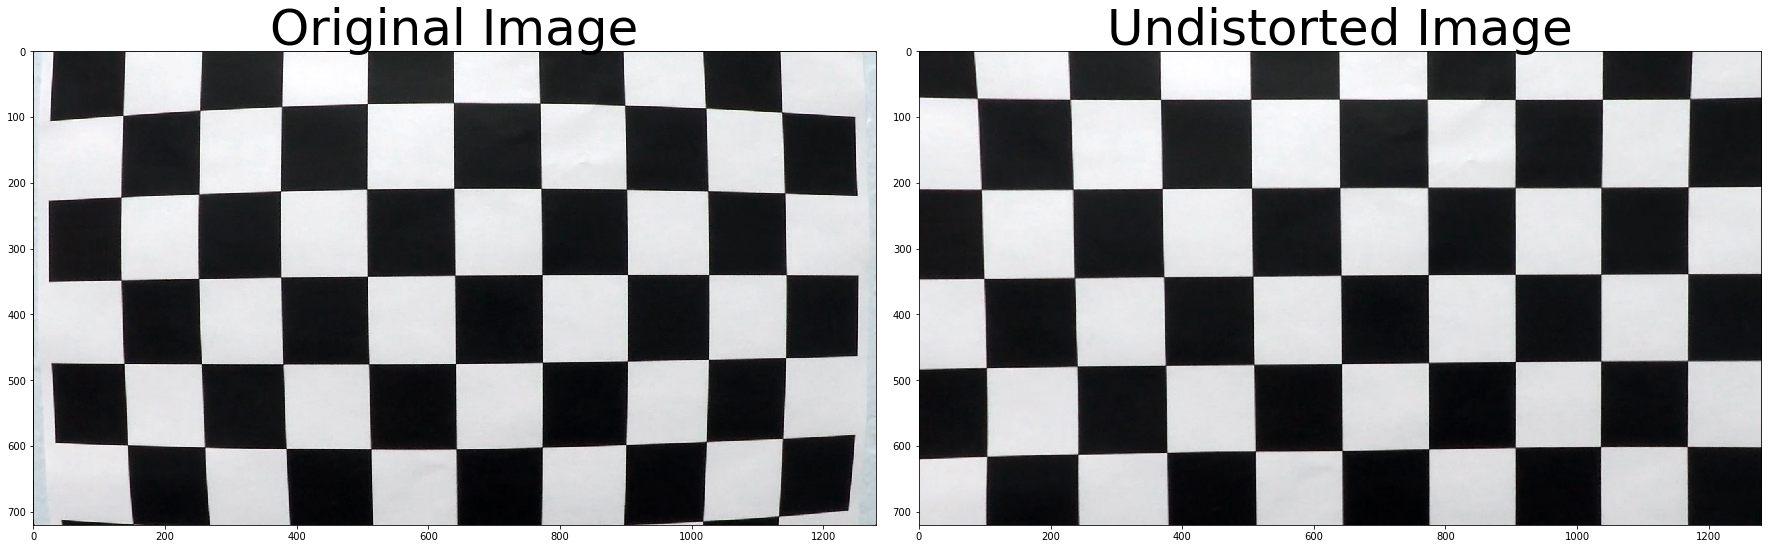

In [174]:
images = ['./camera_cal/calibration1.jpg']
img = cv2.imread(images[0])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistortImage(img))
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/calibration.png')

#### Sample image

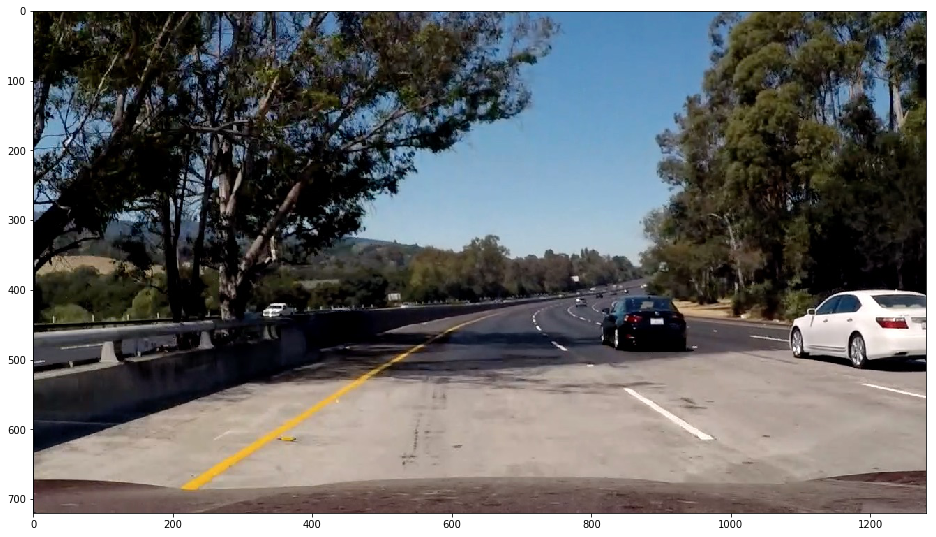

In [119]:
sample_image = mpimg.imread('./test_images/test5.jpg')
plt.imshow(sample_image)

#### Undistorted image

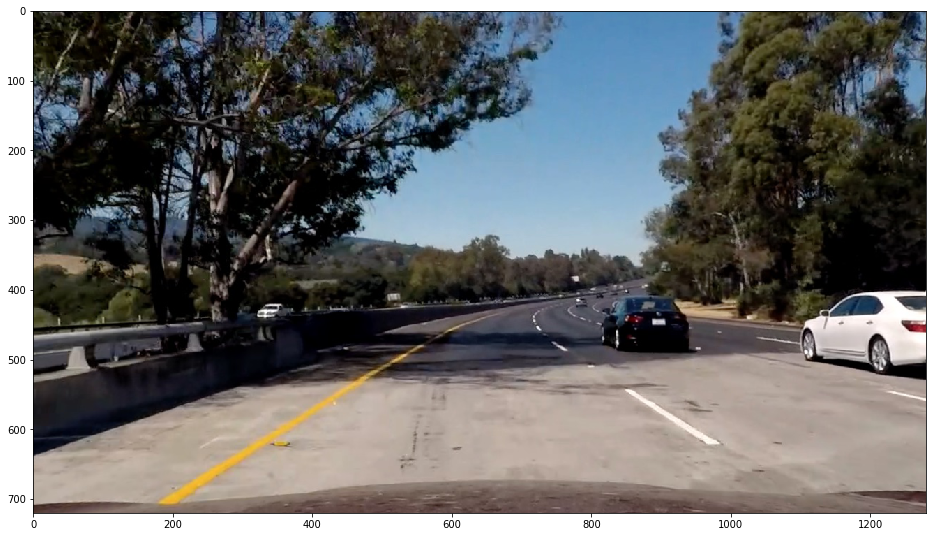

In [120]:
sample_image = mpimg.imread('./test_images/test5.jpg')
sample_undistorted_image = undistortImage(sample_image)
plt.imshow(sample_undistorted_image)
plt.savefig('output_images/undistorted_image.jpg', dpi=300)

#### Perspective transform

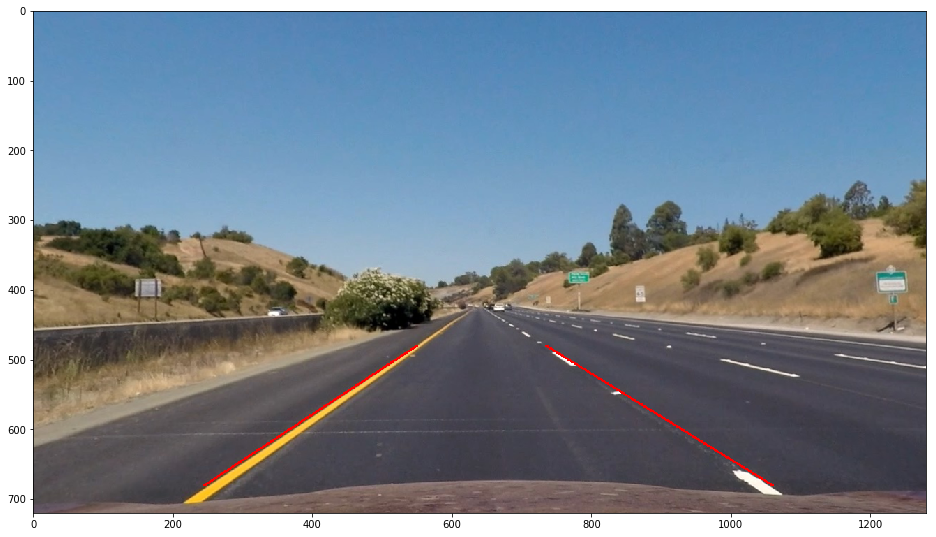

In [202]:
perspective_img = mpimg.imread('./test_images/straight_lines1.jpg')
perspective_undistorted_image = undistortImage(perspective_img)

line1 = [ (245, 680), (550, 480) ]
line2 = [ (1060, 680), (735, 480) ]


cv2.line(perspective_undistorted_image, line1[0], line1[1], [255, 0, 0], 2)
cv2.line(perspective_undistorted_image, line2[0], line2[1], [255, 0, 0], 2)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.imshow(perspective_undistorted_image)
plt.savefig('output_images/perspective_transform.png', dpi=300)

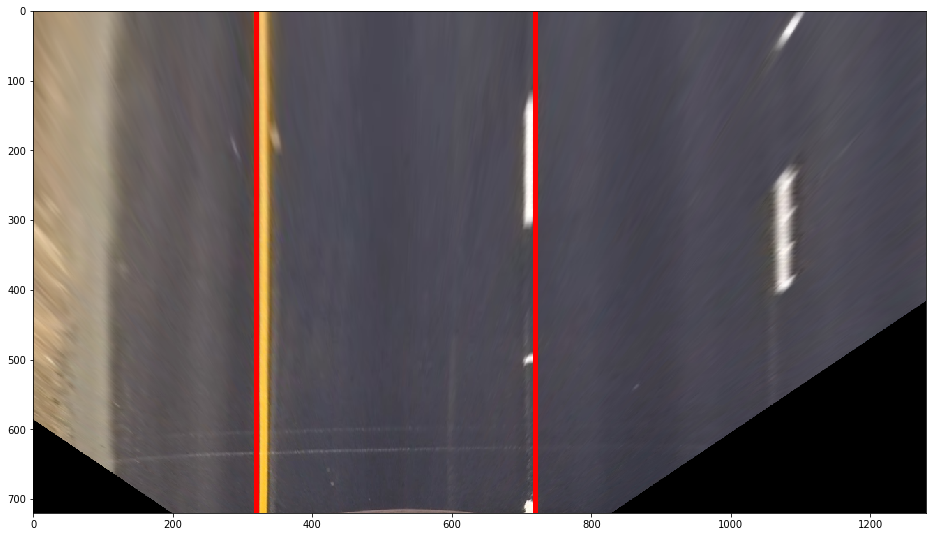

In [206]:
perspective_img = mpimg.imread('./test_images/straight_lines1.jpg')
perspective_undistorted_image = undistortImage(perspective_img)

src_points = np.float32([
    line1[1], # upper left
    line2[1], # upper right
    line2[0], # bottom right
    line1[0], # bottom left
])

dest_points = [
    (320, 0),
    (720, 0),
    (720, 720),
    (320, 720)
]

perspective = PerspectiveTransform(src_points, np.float32(dest_points))
perspective_warped_image = perspective.warp(perspective_undistorted_image)

cv2.line(perspective_warped_image, dest_points[0], dest_points[3], [255, 0, 0], 5)
cv2.line(perspective_warped_image, dest_points[1], dest_points[2], [255, 0, 0], 5)

plt.imshow(perspective_warped_image)
plt.savefig('output_images/perspective_transformed.png', dpi=300)

#### Thresholded Image

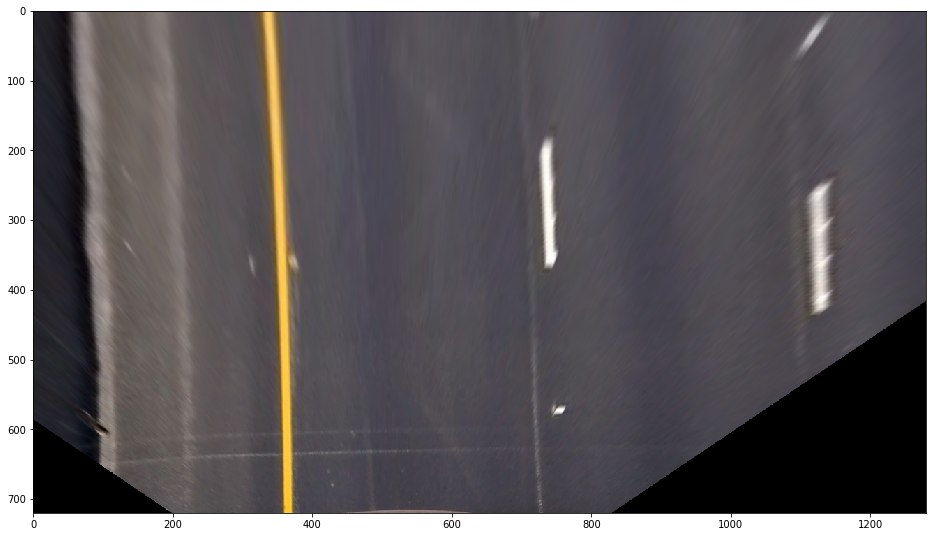

In [217]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
img = mpimg.imread('./test_images/test2.jpg')


undistorted_image = undistortImage(img)

# Create the warped original image (for comparison)
warped_original = perspective.warp(undistorted_image)

# Create the warped and threholded image
thresholded_image = threshold.create_thresholded_image(undistorted_image)
thresholded_and_warped = perspective.warp(thresholded_image)

plt.imshow(thresholded_and_warped, cmap='gray')
plt.savefig('output_images/thresholded.png', dpi=300)
plt.imshow(warped_original)
plt.savefig('output_images/warped.png', dpi=300)

#### Polynomial Fitting

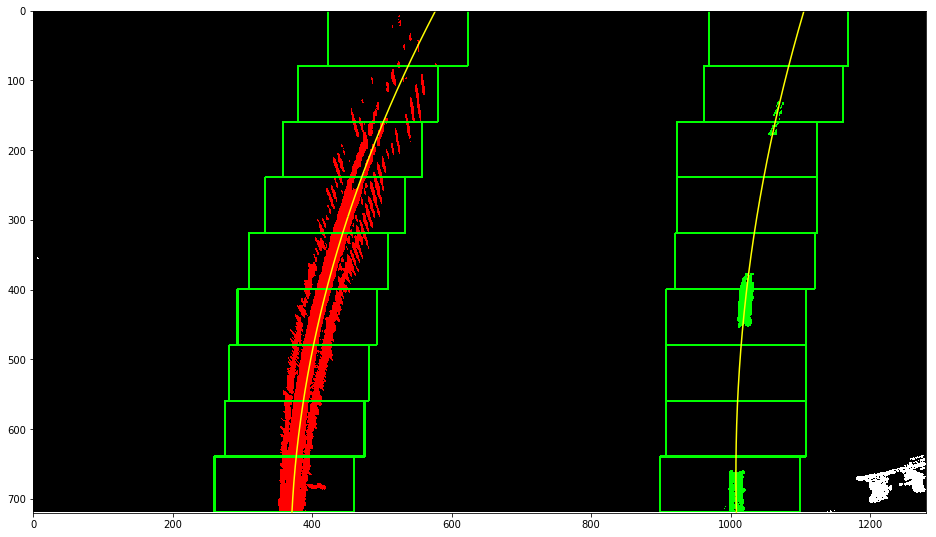

In [191]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
#img = mpimg.imread('./test_images/test5.jpg')
img = mpimg.imread('./test_image_28s.jpg')


undistorted_image = undistortImage(img)
warped = perspective.warp(undistorted_image)
thresholded_image = threshold.create_thresholded_image(warped)


binary_warped = np.copy(thresholded_image)
pfit = PolynomialFitting(num_windows=9, margin=100, minpix=50)
pfit.fit_to_image(binary_warped)

# generate x,y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = pfit.left_poly(ploty)
right_fitx = pfit.right_poly(ploty)

out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped)))*255

out_img[pfit.lefty, pfit.leftx] = [255, 0, 0]
out_img[pfit.righty, pfit.rightx] = [0, 255, 0]

for window in pfit.left_windows:
    cv2.rectangle(out_img, window[0], window[1], (0, 255, 0), 2)
for window in pfit.right_windows:
    cv2.rectangle(out_img, window[0], window[1], (0, 255, 0), 2)

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/polynomial_fitting.png', dpi=300)

#### Final image result

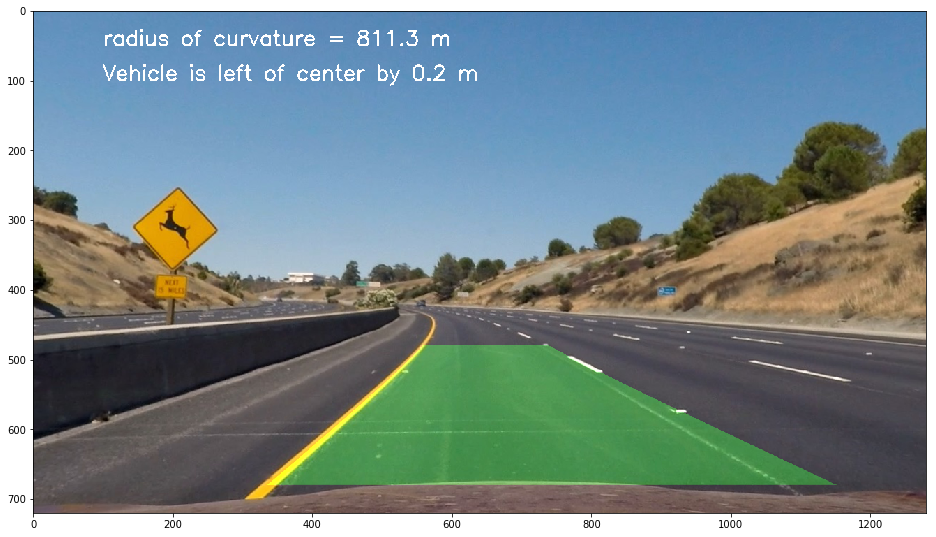

In [231]:
curvFinder = LaneFinder(curv_src_points, curv_dest_points, 7)
lanefinder = LaneFinder(lane_src_points, lane_dest_points, 7, curvature_calculator=curvFinder)
img = mpimg.imread('./test_images/test2.jpg')
#img = mpimg.imread('./test_image_41s.jpg')

out = lanefinder.process_image(img)
plt.imshow(out)
plt.savefig('output_images/final.png', dpi=300)

## Video processing

In [232]:
curvFinder = LaneFinder(curv_src_points, curv_dest_points, 9)
lanefinder = LaneFinder(lane_src_points, lane_dest_points, 9, curvature_calculator=curvFinder)
test_output = "./project_output.mp4"
clip1 = VideoFileClip('./project_video.mp4')
test_clip1 = clip1.fl_image(lanefinder.process_image)
%time test_clip1.write_videofile(test_output, audio=False)
print(lanefinder.stats)
print(curvfinder.stats)

[MoviePy] >>>> Building video ./project_output.mp4
[MoviePy] Writing video ./project_output.mp4


100%|█████████▉| 1260/1261 [05:48<00:00,  3.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_output.mp4 

CPU times: user 6min 47s, sys: 1min 49s, total: 8min 37s
Wall time: 5min 49s
Counter({'sanity_check_passed': 1138, 'image_ok': 1138, 'sanity_check_failed': 122, 'sanity_check::curvature_failure': 122, 'image_skipped': 114, 'image_full_reset': 8})


In [234]:
print(curvFinder.stats)

Counter({'sanity_check_passed': 897, 'image_ok': 897, 'sanity_check_failed': 363, 'image_skipped': 314, 'sanity_check::curvature_failure': 214, 'sanity_check::right_off_center': 94, 'image_full_reset': 49, 'sanity_check::left_off_center': 39, 'sanity_check::not_parallel': 8, 'sanity_check::curve off right edge of frame': 5, 'sanity_check::off_center': 3})


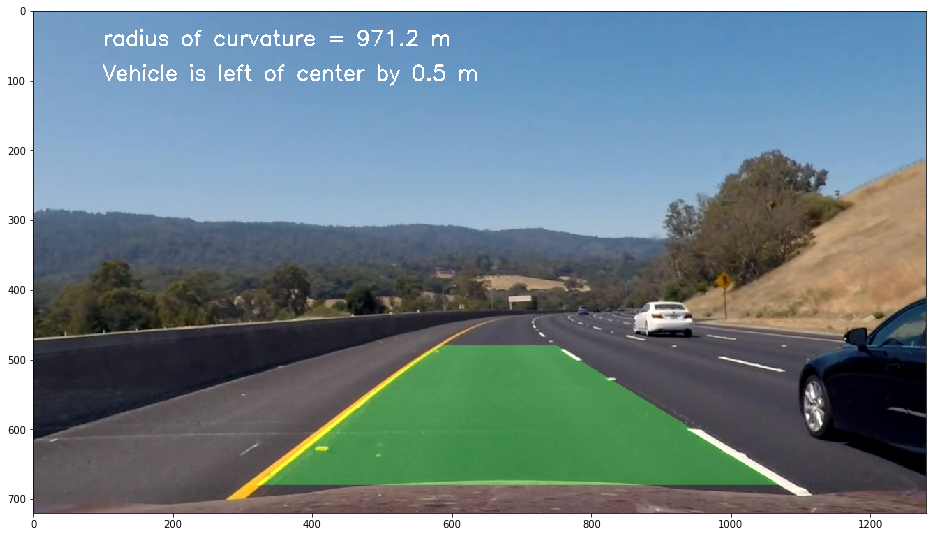

In [226]:
curvFinder = LaneFinder(curv_src_points, curv_dest_points, 9)
lanefinder = LaneFinder(lane_src_points, lane_dest_points, 9, curvature_calculator=curvFinder)

clip = VideoFileClip('./project_video.mp4')
fps = clip.fps

clip_image = clip.get_frame(28)
mpimg.imsave('./test_image_28s.jpg', clip_image)
out = lanefinder.process_image(clip_image)
left_curve, right_curve = lanefinder.calculate_curvature()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size


plt.imshow(out)